# 1. Set up the environment

In [1]:
! pip install setuptools
! python.exe -m pip install --upgrade pip
! pip install --upgrade moku
! pip install numpy ipykernel matplotlib tqdm scipy
! pip install torch
%pip install --q moku[neuralnetwork]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import moku
import sys
print("Python version")
print(sys.version)

Python version
3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [3]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------
MokuLab-002094       2094    Lab    606    10.50.0.51          
MokuGo-000051        51      Go     606    fe80::7269:79ff:feb9:cc%17
MokuPro-000323       323     Pro    606    fe80::7269:79ff:feb0:570%17


## 1.2 Set up the Python environment

In [4]:
import ast
import csv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from pathlib import Path

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

If the following command fails, make sure to download the utils_anomaly_detection file from the tutorial page and save it in the same folder as this notebook.

In [5]:
import utils_anomaly_detection

In [6]:
# set the seed for repeatability
seed = 42
np.random.seed(seed)

In [7]:
quant_mod = LinnModel()

# 3. Load the training dataset download from Moku

In [8]:
def extract_data_from_moku(filename):

    all_samples = []

    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header

        for row in reader:
            sample_n = int(row[0])  # Optional: store or use the sample number
            chunk = ast.literal_eval(row[1])  # Convert string back to list
            all_samples.append(chunk)

    return all_samples


In [28]:
training_samples_anomaly = extract_data_from_moku('training_folder/training_anomaly_precision_20250527_4.csv')
print(f'Data with precison mode loaded from file contains {len(training_samples_anomaly)} frames of {len(training_samples_anomaly[0])} datatpoints each')

training_samples_normal_1 = extract_data_from_moku('training_folder/training_precision_normal_20250528_1.csv')
print(f'Data with normal frames loaded from file contains {len(training_samples_normal_1)} frames of {len(training_samples_normal_1[0])} datatpoints each')
training_samples_normal_2 = extract_data_from_moku('training_folder/training_precision_normal_20250528_2.csv')
print(f'Data with normal frames loaded from file contains {len(training_samples_normal_2)} frames of {len(training_samples_normal_2[0])} datatpoints each')
training_samples_normal_3 = extract_data_from_moku('training_folder/training_precision_normal_20250528_3.csv')
print(f'Data with normal frames loaded from file contains {len(training_samples_normal_3)} frames of {len(training_samples_normal_3[0])} datatpoints each')
training_samples_normal_4 = extract_data_from_moku('training_folder/training_precision_normal_20250528_4.csv')
training_samples_normal_5 = extract_data_from_moku('training_folder/training_precision_normal_20250528_5.csv')
training_samples_normal_6 = extract_data_from_moku('training_folder/training_precision_normal_20250528_6.csv')
training_samples_normal_7 = extract_data_from_moku('training_folder/training_precision_normal_20250528_7.csv')
training_samples_normal_8 = extract_data_from_moku('training_folder/training_precision_normal_20250528_8.csv')
training_samples_normal_9 = extract_data_from_moku('training_folder/training_precision_normal_20250528_9.csv')
training_samples_normal_10 = extract_data_from_moku('training_folder/training_precision_normal_20250528_10.csv')


Data with precison mode loaded from file contains 8 frames of 100 datatpoints each
Data with normal frames loaded from file contains 8 frames of 100 datatpoints each
Data with normal frames loaded from file contains 8 frames of 100 datatpoints each
Data with normal frames loaded from file contains 8 frames of 100 datatpoints each


C:\Users\miche\AppData\Local\Temp\ipykernel_23072\2696258773.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


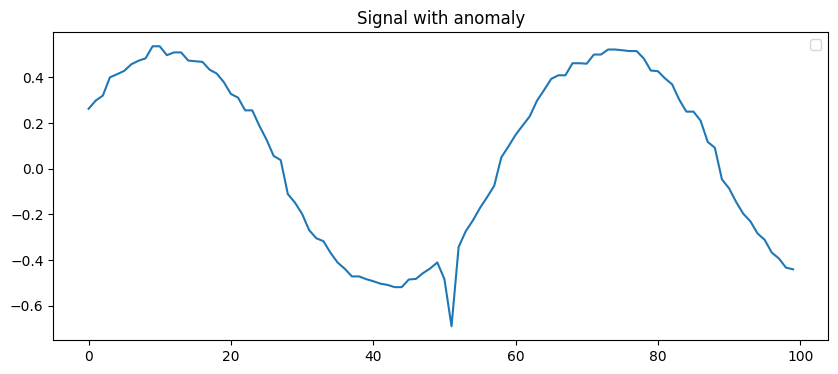

In [13]:
# Plot a sample with anomaly
plt.figure(figsize=(10, 4))
plt.plot(training_samples_anomaly[1])
plt.title('Signal with anomaly')
plt.legend(loc='upper right') 

C:\Users\miche\AppData\Local\Temp\ipykernel_23072\2655709691.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


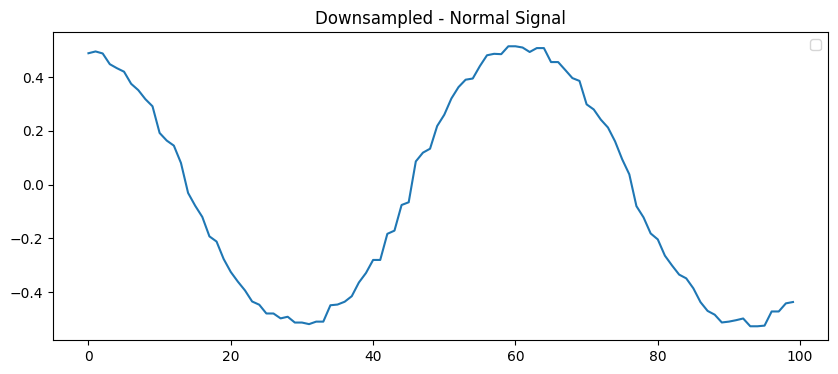

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(training_samples_normal_1[3])
plt.title('Downsampled - Normal Signal')
plt.legend(loc='upper right') 

### 4.1 Split the training dataset into training and validation sets.
80/20 split is used in this tutorial.

In [30]:
full_training_dataset = training_samples_anomaly + training_samples_normal_1 + training_samples_normal_2 + training_samples_normal_3 + training_samples_normal_4 + training_samples_normal_5 + training_samples_normal_6 + training_samples_normal_7 + training_samples_normal_8 + training_samples_normal_9 + training_samples_normal_10
anomaly_count = len(training_samples_anomaly)
print(f"frames with anomaly:", anomaly_count)
print(f"NORMAL frames:", len(full_training_dataset) - anomaly_count)

frames with anomaly: 8
NORMAL frames: 80


In [31]:
train_size = int(0.8 * len(full_training_dataset))
val_size = len(full_training_dataset) - train_size

indices = list(range(len(full_training_dataset)))


# Split the indices into training and validation sets
train_indices = indices[:train_size]
val_indices = indices[train_size:]

print(f"Tot n. of frames in the training dataset: {train_size}")
print(f"Tot n. of frames in the validation dataset: {val_size}")

Tot n. of frames in the training dataset: 70
Tot n. of frames in the validation dataset: 18


In [32]:
total_size_full = len(full_training_dataset)

# Find anomaly indices (first 10 from each half)
anomaly_indices = list(range(0, anomaly_count))

# All other indices are normal
normal_indices = list(range(anomaly_count, total_size_full))

total_size = total_size_full - len(anomaly_indices)
train_size = int(0.8 * total_size)
val_size = total_size - train_size


# Shuffle for random sampling
np.random.shuffle(anomaly_indices)
np.random.shuffle(normal_indices)

# Select anomalies
num_train_anomalies = int(0.8*len(anomaly_indices))
num_val_anomalies = len(anomaly_indices) - num_train_anomalies
train_anomaly_indices = anomaly_indices[:num_train_anomalies]
val_anomaly_indices = anomaly_indices[num_train_anomalies:num_train_anomalies + num_val_anomalies]

# Select normals
train_normal_indices = normal_indices[:train_size]
val_normal_indices = normal_indices[train_size:]

print(f"Normal frames: {len(train_normal_indices)} in the training dataset and {len(val_normal_indices)} in the validation")

# Combine and shuffle
train_indices = train_anomaly_indices + train_normal_indices
val_indices = val_anomaly_indices + val_normal_indices

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)


print(f"Anomalies in train: {len([i for i in train_indices if i in train_anomaly_indices])}")
print(f"Anomalies in validation: {len([i for i in val_indices if i in val_anomaly_indices])}")

Normal frames: 64 in the training dataset and 16 in the validation
Anomalies in train: 6
Anomalies in validation: 2


In [33]:
# Create train and validation datasets with the generated indices
training_inputs = [full_training_dataset[i] for i in train_indices]
validation_inputs = [full_training_dataset[i] for i in val_indices]

## 5. Define the model and train

In [34]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [35]:
# model definition for an autoencoder
frame_length = len(training_inputs[0])

# train the model
quant_mod.set_training_data(training_inputs=training_inputs, training_outputs=training_inputs)
model_definition = [(64, 'relu'), (32, 'relu'), (16, 'relu'), (frame_length, 'linear')]

# build the model
#quant_mod.construct_model(model_definition, show_summary=True)
quant_mod.construct_model(model_definition)

In [36]:
history = quant_mod.fit_model(epochs=100, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.5864 - val_loss: 0.5553
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.5558 - val_loss: 0.5374
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5375 - val_loss: 0.5281
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5267 - val_loss: 0.5211
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5170 - val_loss: 0.5156
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5134 - val_loss: 0.5109
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5069 - val_loss: 0.5068
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5057 - val_loss: 0.5024
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4970 - val_loss: 0.4981
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4898 - val_loss: 0.4934
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.4867 - val_loss: 0.4881
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4796 - val_l

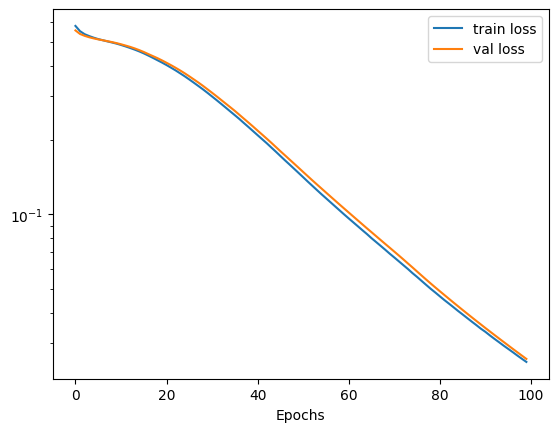

In [37]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

In [38]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='AD_autoencoder.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


# 6. Testing the model - reconstruct the training dataset
This is used to see how well the model has learnt to reconstruct the data from the training dataset

**Reconstruction error** in the context of te autoencoders is the difference between the original input signal and the signal the model tries to reconstruct after encoding and decoding it. In our code, this would be the difference between training_inputs and reconstructions variables.

When the autoencoder is trained on normal data (that may contains sporadic anomalies like our training dataset), it learns the typical shape and patterns of the signal. So, when the AutoEncoder sees something unusual or unexpected (an anomaly), it struggles to reconstruct it accurately — resulting in a higher reconstruction error. 

By looking at where this error is large, we can spot potential anomalies that deviate from the learned normal behavior.

In [39]:
reconstructions = []
reconstructions = quant_mod.predict(full_training_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


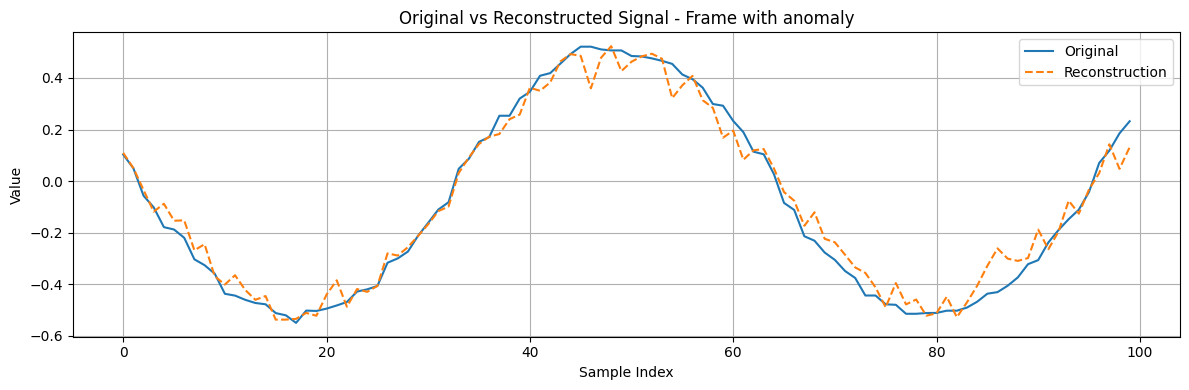

In [40]:
frame_id_normal = int(len(full_training_dataset)/2) + 1

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_normal], label='Original')
plt.plot(reconstructions[frame_id_normal], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal - Frame with anomaly')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


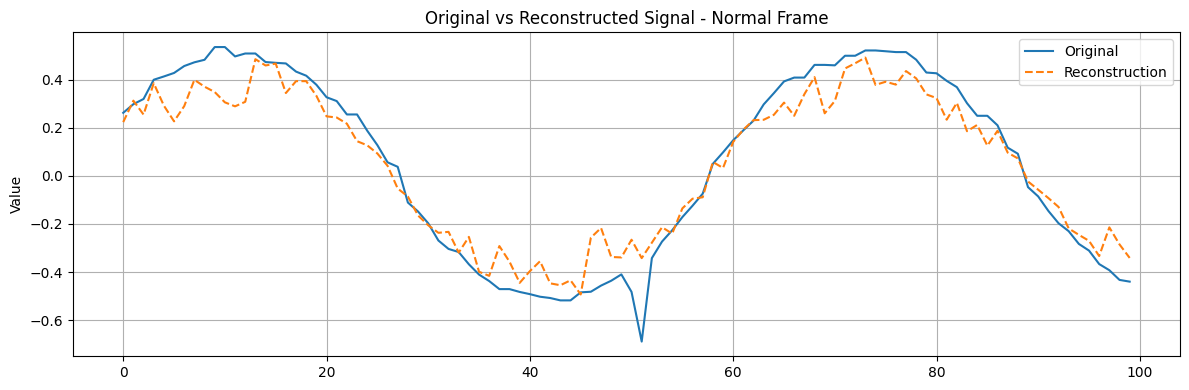

In [42]:
frame_id_anomaly = 1

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_anomaly], label='Original')
plt.plot(reconstructions[frame_id_anomaly], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal - Normal Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:

original = np.array(full_training_dataset)
reconstructed = np.array(reconstructions)

# --- Error Calculations ---
# Element-wise absolute error
absolute_error = np.abs(original - reconstructed)

# Element-wise squared error
squared_error = (original - reconstructed) ** 2

# Total error per sample (row-wise)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)


### Absolute error

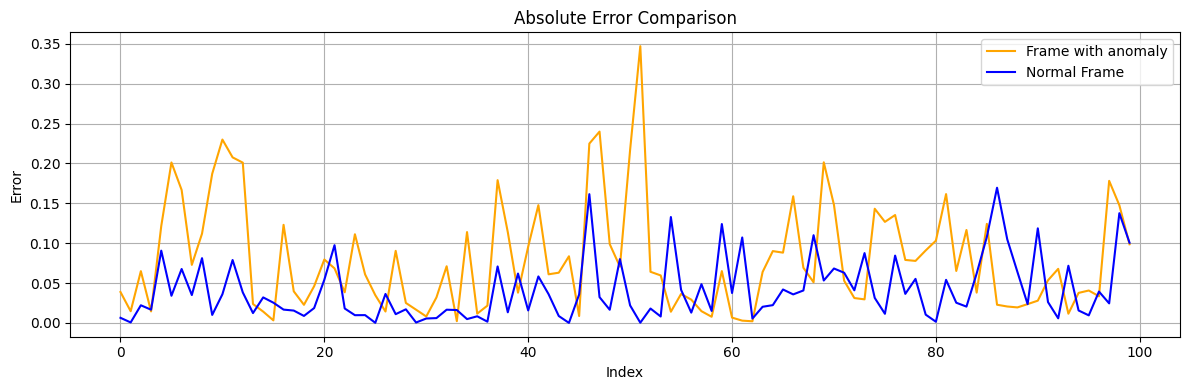

In [44]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(absolute_error[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(absolute_error[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Absolute Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
threshold = 0.15

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_normal]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_normal][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [5, 6, 9, 10, 11, 12, 37, 46, 47, 50, 51, 66, 69, 81, 97]
Corresponding values: [np.float64(0.2012138318092117), np.float64(0.16674358860023314), np.float64(0.18708556669503906), np.float64(0.22996186989099243), np.float64(0.20761151402852662), np.float64(0.20100226747703676), np.float64(0.17902437109106384), np.float64(0.22490390445539427), np.float64(0.23993651958430512), np.float64(0.21703770826179197), np.float64(0.34706747556202266), np.float64(0.15881617602928283), np.float64(0.20139049815309146), np.float64(0.1616036957896359), np.float64(0.1781753870345401)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: [46, 86]
Corresponding values: [np.float64(0.16147258380250973), np.float64(0.16954443568320066)]


### Squared error

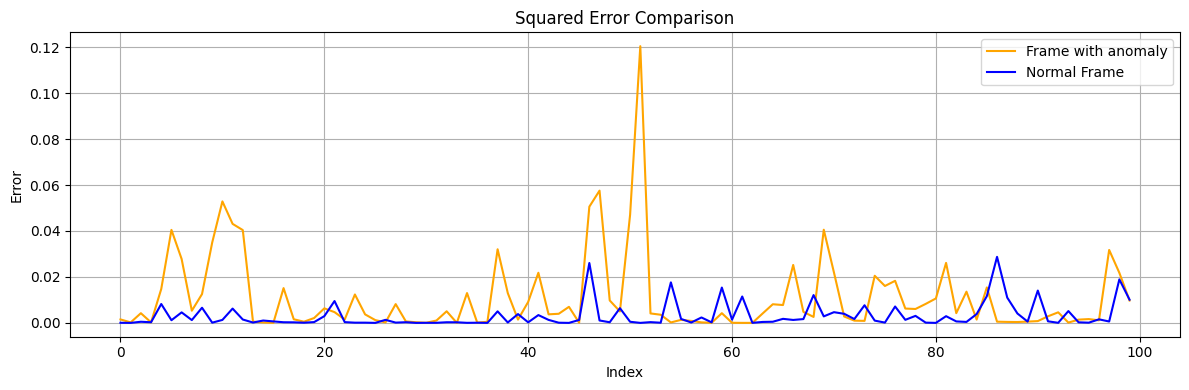

In [46]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(squared_error[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
threshold = 0.03

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_normal]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_normal][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [5, 9, 10, 11, 12, 37, 46, 47, 50, 51, 69, 97]
Corresponding values: [np.float64(0.04048700611134574), np.float64(0.035001009265603907), np.float64(0.052882461603761734), np.float64(0.0431025407572171), np.float64(0.04040191153091023), np.float64(0.03204972544455093), np.float64(0.050581766239281116), np.float64(0.057569533430229636), np.float64(0.047105366807530726), np.float64(0.1204558325929952), np.float64(0.04055813274635033), np.float64(0.03174646854490817)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


### Focal loss

In [48]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error ** 2
    loss = squared_error ** gamma
    return loss

In [49]:
# --- Focal Loss Calculation ---
focal_loss = focal_mse_loss(reconstructed, original)  # element-wise focal loss

# Total focal loss per sample (row-wise sum)
focal_loss_per_frame = focal_loss.sum(axis=1)

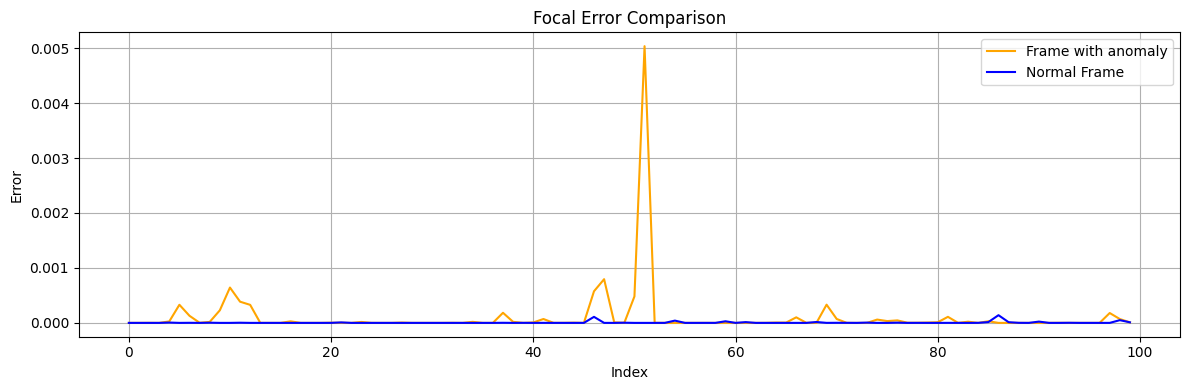

In [50]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(focal_loss[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Focal Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
threshold = 0.0001

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_normal]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_normal][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [5, 6, 9, 10, 11, 12, 37, 46, 47, 50, 51, 66, 69, 81, 97]
Corresponding values: [np.float64(0.00032982924303800835), np.float64(0.00012889786382517065), np.float64(0.00022919303672391307), np.float64(0.0006431009584755839), np.float64(0.0003857066955917725), np.float64(0.0003280989067611952), np.float64(0.00018389113090848947), np.float64(0.0005754200301745886), np.float64(0.0007952098930072547), np.float64(0.0004815883527592908), np.float64(0.0050358128830959945), np.float64(0.00010103542541235443), np.float64(0.00033127974318038645), np.float64(0.00011021899409859703), np.float64(0.00017957197294757337)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: [46, 86]
Corresponding values: [np.float64(0.00010977260574349636), np.float64(0.00014009340973079472)]
